### Import Modules

In [2]:
# general
import pandas as pd
import numpy as np
import requests as rq
import re
import random

#sklearn
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, roc_curve, auc, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, svm, exceptions, tree
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, cross_validate

# scraping
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact, interactive, HBox, VBox, interactive_output
from ipywidgets import widgets

from IPython.display import display
plt.style.use('fivethirtyeight')

### Load Data

In [3]:
homeruns = pd.read_csv('class_data.csv')
homeruns = homeruns.drop(['Unnamed: 0'], axis=1)
homeruns['event'] = (homeruns['event'] == 'YES').astype(int)
homeruns.head()

,batter_BB,batter_K,batter_AVG,batter_OBP,batter_SLG,batter_ISO,batter_wRC,batter_wRAA,batter_wOBA,batter_LD,...,split_pitcher_OBP,split_pitcher_SLG,split_pitcher_ISO,split_pitcher_WHIP,split_pitcher_FIP,split_pitcher_LD,split_pitcher_FB,split_pitcher_HRFB,HZ_Score,event
0,0.194087,0.233933,0.251223,0.397668,0.303426,0.089723,99.363178,6.628051,0.328138,0.285383,...,0.381356,0.437500,0.217105,1.780822,3.563816,0.271795,0.312821,0.163934,136,0
1,0.194087,0.233933,0.251223,0.397668,0.303426,0.089723,99.363178,6.628051,0.328138,0.285383,...,0.381356,0.437500,0.217105,1.780822,3.563816,0.271795,0.312821,0.163934,136,0
2,0.194087,0.233933,0.251223,0.397668,0.303426,0.089723,99.363178,6.628051,0.328138,0.285383,...,0.381356,0.437500,0.217105,1.780822,3.563816,0.271795,0.312821,0.163934,136,0
3,0.194087,0.233933,0.251223,0.397668,0.303426,0.089723,99.363178,6.628051,0.328138,0.285383,...,0.278999,0.315031,0.175704,1.137755,2.626424,0.293182,0.226136,0.165829,103,0
4,0.194087,0.233933,0.251223,0.397668,0.303426,0.089723,99.363178,6.628051,0.328138,0.285383,...,0.278999,0.315031,0.175704,1.137755,2.626424,0.293182,0.226136,0.165829,103,0


## Base Model

#### Data pre-processing

In [4]:
homeruns.to_csv('homeruns.csv')

In [5]:
X = homeruns.loc[:, 'batter_BB':'HZ_Score']
y = homeruns.loc[:, 'event']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# create polynomial features
poly_degree = 2

# normalize data
std = StandardScaler()

# split polynomial features
pf = PolynomialFeatures(degree = poly_degree)
features = homeruns.loc[:, 'batter_BB':'HZ_Score'].columns.tolist()
pf.fit(homeruns[features])
feat_array = pf.transform(homeruns[features])
homeruns_poly = pd.DataFrame(feat_array, columns = pf.get_feature_names(input_features=features))
X_poly = homeruns_poly.loc[:,pf.get_feature_names(input_features=features)]
y_poly = homeruns['event']
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y_poly, test_size=0.2, random_state=42)

# transform linear features
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

# transform polynomial features
std.fit(X_poly_train.values)
X_poly_tr = std.transform(X_poly_train.values)
X_poly_te = std.transform(X_poly_test.values)

#### CV

In [7]:
lr = LogisticRegression(solver='liblinear')
gnb = GaussianNB()
svm = SVC(gamma='auto')
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

In [8]:
scaled_models = [lr, gnb]
unscaled_models = [dt, rf]

In [9]:
base_metrics = []
base_unscaled_metrics = []

for model in scaled_models:
    model.fit(X_tr, y_train);
    preds = model.predict(X_te)
    model_CV = np.mean(cross_val_score(model, X_tr, y_train, cv=2))
    model_acc = accuracy_score(y_test, preds)
    model_prec = precision_score(y_test, preds)
    model_rec = recall_score(y_test, preds)
    model_f1 = f1_score(y_test, preds)
    base_metrics.append([str(model)[0:5], model_CV, model_acc, model_prec, model_rec, model_f1])
    
for model in unscaled_models:
    model.fit(X_train, y_train);
    preds = model.predict(X_test)
    model_CV = np.mean(cross_val_score(model, X_train, y_train, cv=2))
    model_acc = accuracy_score(y_test, preds)
    model_prec = precision_score(y_test, preds)
    model_rec = recall_score(y_test, preds)
    model_f1 = f1_score(y_test, preds)
    base_unscaled_metrics.append([str(model)[0:5], model_CV, model_acc, model_prec, model_rec, model_f1])
    
model_selection = pd.DataFrame(base_metrics, columns = ['model', 'CV', 'Accuracy', 'Precision', 'Recall', 'F1'])
base_selection_unscaled = pd.DataFrame(base_unscaled_metrics, columns = ['model', 'CV', 'Accuracy', 'Precision', 'Recall', 'F1'])
model_selection = model_selection.append(base_selection_unscaled)

/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [10]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='auc')
        
    #Predict training set:
    predictions = alg.predict(X_train)
    predprob = alg.predict_proba(X_train)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, predprob))
    print(alg.get_booster().best_iteration)
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [11]:
X_train = X_train[:1000]
y_train = y_train[:1000]


Model Report
Accuracy : 0.973
AUC Score (Train): 0.976971
21


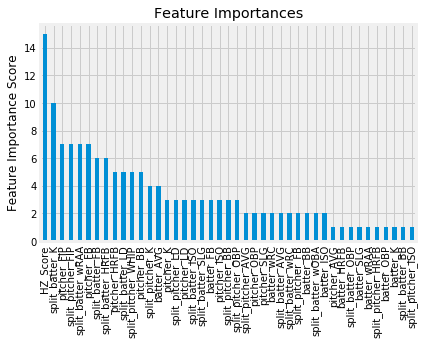

In [12]:
predictors = X_train.columns.values
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27,
    verbose=True)
modelfit(xgb1, homeruns, predictors)

In [13]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=21, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/matt/anaconda3/lib/python3.

({'mean_fit_time': array([0.05617762, 0.05418382, 0.04480023, 0.06252222, 0.04977393,
         0.04688134, 0.06884618, 0.04724035, 0.04809361, 0.07436619,
         0.05204473, 0.04649353]),
  'std_fit_time': array([0.00334993, 0.00394285, 0.00296072, 0.00315077, 0.00266131,
         0.002302  , 0.00502663, 0.00316737, 0.00115738, 0.00526715,
         0.0037811 , 0.00308767]),
  'mean_score_time': array([0.00307598, 0.00290523, 0.00227623, 0.00230021, 0.00222759,
         0.00266185, 0.0023809 , 0.00216608, 0.00258222, 0.00248675,
         0.00213261, 0.00213661]),
  'std_score_time': array([0.00023452, 0.00028708, 0.00023477, 0.00026997, 0.00024745,
         0.00023966, 0.00020903, 0.00018868, 0.0003684 , 0.00035519,
         0.00022127, 0.00018431]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
         

In [14]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[0,1,2]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=21, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/matt/anaconda3/lib/python3.

({'mean_fit_time': array([0.04313006, 0.03943405, 0.03172746, 0.03993382, 0.03945723,
         0.03685741, 0.04687719, 0.0465126 , 0.04175825]),
  'std_fit_time': array([0.00095224, 0.00383322, 0.00124494, 0.00039813, 0.00045706,
         0.00101103, 0.000522  , 0.00273567, 0.00258845]),
  'mean_score_time': array([0.00277591, 0.00221214, 0.00192618, 0.00194058, 0.00196157,
         0.00197701, 0.00192537, 0.00216837, 0.00206099]),
  'std_score_time': array([3.82620001e-04, 3.38103222e-04, 5.45471281e-05, 3.65447077e-05,
         8.68323738e-05, 8.45342853e-05, 5.93785001e-05, 3.04370032e-04,
         2.85260815e-04]),
  'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 4, 4, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[0, 1, 2, 0, 1, 2, 0, 1, 2],
               mask=[False, False, False, False, False, False, False, 

In [15]:
param_test2b = {
 'min_child_weight':[1,3,5,7]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=2, missing=None, n_estimators=140, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [1, 3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)


Model Report
Accuracy : 0.974
AUC Score (Train): 0.923528
20


/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/matt/anaconda3/lib/python3.

({'mean_fit_time': array([0.30004215, 0.2443923 , 0.20996432, 0.18702374]),
  'std_fit_time': array([0.0098132 , 0.00369494, 0.00250976, 0.0010863 ]),
  'mean_score_time': array([0.00278273, 0.00246735, 0.00252304, 0.00213385]),
  'std_score_time': array([2.50702214e-04, 6.40865238e-05, 1.51864782e-04, 5.99778887e-05]),
  'param_min_child_weight': masked_array(data=[1, 3, 5, 7],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 1},
   {'min_child_weight': 3},
   {'min_child_weight': 5},
   {'min_child_weight': 7}],
  'split0_test_score': array([0.68888889, 0.59316239, 0.64786325, 0.60512821]),
  'split1_test_score': array([0.53119658, 0.55940171, 0.49615385, 0.5525641 ]),
  'split2_test_score': array([0.40615385, 0.45538462, 0.48307692, 0.48717949]),
  'split3_test_score': array([0.3556701 , 0.32680412, 0.39587629, 0.36907216]),
  'split4_test_score': array([0.54123711, 0.56701031, 0.68350515, 0.675

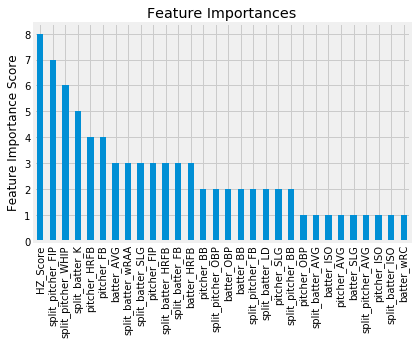

In [16]:
modelfit(gsearch2.best_estimator_, X_train, X_train)
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

In [18]:
gbm = xgb.XGBClassifier( 
                        n_estimators=21,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.1, 
                        subsample=.8,
                        min_child_weight=5,
                        colsample_bytree=.8
                       )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,random_state=42)
eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )
base_xgb_metrics = []
xgb_CV = 0
xgb_acc = accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))
xgb_prec = precision_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))
xgb_rec = recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))
xgb_f1 =f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))
base_xgb_metrics.append(['Xgb', xgb_CV, xgb_acc, xgb_prec, xgb_rec, xgb_f1])

base_xgb = pd.DataFrame(base_xgb_metrics, columns = ['model', 'CV', 'Accuracy', 'Precision', 'Recall', 'F1'])
model_selection = model_selection.append(base_xgb)
model_selection.sort_values(by=['F1'], ascending=False).head(len(scaled_models)*4).reset_index().drop(['index'], axis=1)

/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,model,CV,Accuracy,Precision,Recall,F1
0,Rando,0.973493,0.976187,0.600526,0.294080,0.394816
1,Decis,0.973340,0.976332,0.619013,0.270270,0.376260
2,Gauss,0.846833,0.845565,0.058499,0.321107,0.098969
3,Logis,0.972845,0.973561,0.363636,0.001287,0.002565
4,Xgb,0.000000,0.973587,0.000000,0.000000,0.000000
5,Xgb,0.000000,0.973587,0.000000,0.000000,0.000000


### Class imbalance issues

0    0.973014
1    0.026986
Name: event, dtype: float64
0    572461
1     15877
Name: event, dtype: int64


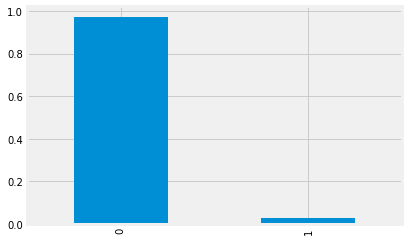

In [19]:
target_pcts = homeruns.event.value_counts(normalize=True) 
print(target_pcts)
print(homeruns.event.value_counts())
target_pcts.plot(kind='bar');

In [20]:
# Combine majority class with upsampled minority class
df_sampling = X_train.copy()
df_sampling['event'] = y_train.values
df_sampling.head()

,batter_BB,batter_K,batter_AVG,batter_OBP,batter_SLG,batter_ISO,batter_wRC,batter_wRAA,batter_wOBA,batter_LD,...,split_pitcher_OBP,split_pitcher_SLG,split_pitcher_ISO,split_pitcher_WHIP,split_pitcher_FIP,split_pitcher_LD,split_pitcher_FB,split_pitcher_HRFB,HZ_Score,event
37829,0.140411,0.418950,0.174797,0.297018,0.315718,0.176152,75.05547,-30.47495,0.276601,0.315364,...,0.334778,0.352243,0.197889,1.490228,4.299208,0.236957,0.223913,0.310680,142,0
169181,0.153676,0.275465,0.225094,0.349355,0.405493,0.210016,293.87710,24.89689,0.331121,0.226721,...,0.307153,0.388800,0.214400,1.311741,3.440800,0.281065,0.257396,0.344828,102,0
347498,0.132637,0.342042,0.214892,0.324900,0.475024,0.306786,344.08130,48.31594,0.341109,0.229740,...,0.292166,0.305331,0.171244,1.225225,2.382714,0.288571,0.221429,0.135484,94,0
301017,0.100537,0.236213,0.253591,0.339294,0.446409,0.262983,282.49780,38.89303,0.340588,0.299397,...,0.281426,0.420082,0.227459,1.166667,3.431967,0.208754,0.370370,0.227273,83,0
169813,0.153676,0.275465,0.225094,0.349355,0.405493,0.210016,293.87710,24.89689,0.331121,0.226721,...,0.286344,0.411694,0.202864,1.206522,3.955609,0.252613,0.172474,0.444444,84,0


In [21]:
df_majority = df_sampling[df_sampling.event==0]
df_minority = df_sampling[df_sampling.event==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True,
                                 n_samples=df_sampling.event.value_counts()[0],
                                 random_state=123)
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.head()

,batter_BB,batter_K,batter_AVG,batter_OBP,batter_SLG,batter_ISO,batter_wRC,batter_wRAA,batter_wOBA,batter_LD,...,split_pitcher_OBP,split_pitcher_SLG,split_pitcher_ISO,split_pitcher_WHIP,split_pitcher_FIP,split_pitcher_LD,split_pitcher_FB,split_pitcher_HRFB,HZ_Score,event
37829,0.140411,0.418950,0.174797,0.297018,0.315718,0.176152,75.05547,-30.47495,0.276601,0.315364,...,0.334778,0.352243,0.197889,1.490228,4.299208,0.236957,0.223913,0.310680,142,0
169181,0.153676,0.275465,0.225094,0.349355,0.405493,0.210016,293.87710,24.89689,0.331121,0.226721,...,0.307153,0.388800,0.214400,1.311741,3.440800,0.281065,0.257396,0.344828,102,0
347498,0.132637,0.342042,0.214892,0.324900,0.475024,0.306786,344.08130,48.31594,0.341109,0.229740,...,0.292166,0.305331,0.171244,1.225225,2.382714,0.288571,0.221429,0.135484,94,0
301017,0.100537,0.236213,0.253591,0.339294,0.446409,0.262983,282.49780,38.89303,0.340588,0.299397,...,0.281426,0.420082,0.227459,1.166667,3.431967,0.208754,0.370370,0.227273,83,0
169813,0.153676,0.275465,0.225094,0.349355,0.405493,0.210016,293.87710,24.89689,0.331121,0.226721,...,0.286344,0.411694,0.202864,1.206522,3.955609,0.252613,0.172474,0.444444,84,0


In [22]:
target_pcts = df_upsampled.event.value_counts(normalize=True) 
print(target_pcts)
print(df_upsampled.event.value_counts())

1    0.5
0    0.5
Name: event, dtype: float64
1    546
0    546
Name: event, dtype: int64


In [23]:
X = df_upsampled.loc[:, 'batter_BB':'HZ_Score']
y = df_upsampled.loc[:, 'event']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# create polynomial features
poly_degree = 2

# normalize data
std = StandardScaler()

# split polynomial features
pf = PolynomialFeatures(degree = poly_degree)
features = homeruns.loc[:, 'batter_BB':'HZ_Score'].columns.tolist()
pf.fit(homeruns[features])
feat_array = pf.transform(homeruns[features])
homeruns_poly = pd.DataFrame(feat_array, columns = pf.get_feature_names(input_features=features))
X_poly = homeruns_poly.loc[:,pf.get_feature_names(input_features=features)]
y_poly = homeruns['event']
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y_poly, test_size=0.2, random_state=42)

# transform linear features
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

# transform polynomial features
std.fit(X_poly_train.values)
X_poly_tr = std.transform(X_poly_train.values)
X_poly_te = std.transform(X_poly_test.values)

In [25]:
upsampled_metrics = []
upsampled_unscaled_metrics = []

for model in scaled_models:
    model.fit(X_tr, y_train);
    preds = model.predict(X_te)
    model_CV = np.mean(cross_val_score(model, X_tr, y_train, cv=2))
    model_acc = accuracy_score(y_test, preds)
    model_prec = precision_score(y_test, preds)
    model_rec = recall_score(y_test, preds)
    model_f1 = f1_score(y_test, preds)
    upsampled_metrics.append([str(model)[0:5] + str(' upsamp'), model_CV, model_acc, model_prec, model_rec, model_f1])
    
for model in unscaled_models:
    model.fit(X_train, y_train);
    preds = model.predict(X_test)
    model_CV = np.mean(cross_val_score(model, X_train, y_train, cv=2))
    model_acc = accuracy_score(y_test, preds)
    model_prec = precision_score(y_test, preds)
    model_rec = recall_score(y_test, preds)
    model_f1 = f1_score(y_test, preds)
    upsampled_unscaled_metrics.append([str(model)[0:5] + str(' upsamp'), model_CV, model_acc, model_prec, model_rec, model_f1])
    
upsampled_selection = pd.DataFrame(upsampled_metrics, columns = ['model', 'CV', 'Accuracy', 'Precision', 'Recall', 'F1'])
upsampled_selection_unscaled = pd.DataFrame(upsampled_unscaled_metrics, columns = ['model', 'CV', 'Accuracy', 'Precision', 'Recall', 'F1'])
model_selection = model_selection.append(upsampled_selection)
model_selection = model_selection.append(upsampled_selection_unscaled)

In [27]:
model_selection.sort_values(by=['F1'], ascending=False).head(len(scaled_models)*4).reset_index().drop(['index'], axis=1)

,model,CV,Accuracy,Precision,Recall,F1
0,Rando upsamp,0.998853,0.990868,0.980392,1.000000,0.990099
1,Decis upsamp,0.967911,0.963470,0.925926,1.000000,0.961538
2,Logis upsamp,0.911800,0.917808,0.847458,1.000000,0.917431
3,Gauss upsamp,0.742290,0.730594,0.672269,0.800000,0.730594
4,Rando,0.973493,0.976187,0.600526,0.294080,0.394816
5,Decis,0.973340,0.976332,0.619013,0.270270,0.376260
6,Gauss,0.846833,0.845565,0.058499,0.321107,0.098969
7,Logis,0.972845,0.973561,0.363636,0.001287,0.002565


In [35]:
gbm = xgb.XGBClassifier( 
                        n_estimators=21,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.1, 
                        subsample=.8,
                        min_child_weight=5,
                        colsample_bytree=.8
                       )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,random_state=42)
eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )
upsampled_xgb_metrics = []
xgb_CV = 0
xgb_acc = accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))
xgb_prec = precision_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))
xgb_rec = recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))
xgb_f1 =f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))
upsampled_xgb_metrics.append(['Xgb upsamp', xgb_CV, xgb_acc, xgb_prec, xgb_rec, xgb_f1])

upsampled_xgb = pd.DataFrame(upsampled_xgb_metrics, columns = ['model', 'CV', 'Accuracy', 'Precision', 'Recall', 'F1'])
model_selection = model_selection.append(upsampled_xgb)
model_selection = model_selection.sort_values(by=['F1'], ascending=False).head(len(scaled_models)*6).reset_index().drop(['index'], axis=1)
model_selection.head(20)

,model,CV,Accuracy,Precision,Recall,F1
0,Rando upsamp,0.998853,0.990868,0.980392,1.000000,0.990099
1,Decis upsamp,0.967911,0.963470,0.925926,1.000000,0.961538
2,Xgb upsamp,0.000000,0.949772,0.900901,1.000000,0.947867
3,Xgb upsamp,0.000000,0.945205,0.892857,1.000000,0.943396
4,Xgb upsamp,0.000000,0.931507,0.869565,1.000000,0.930233
5,Logis upsamp,0.911800,0.917808,0.847458,1.000000,0.917431
6,Gauss upsamp,0.742290,0.730594,0.672269,0.800000,0.730594
7,Rando,0.973493,0.976187,0.600526,0.294080,0.394816
8,Decis,0.973340,0.976332,0.619013,0.270270,0.376260
9,Gauss,0.846833,0.845565,0.058499,0.321107,0.098969


In [39]:
model_selection.head(12)

,model,CV,Accuracy,Precision,Recall,F1
0,Rando upsamp,0.998853,0.990868,0.980392,1.000000,0.990099
1,Decis upsamp,0.967911,0.963470,0.925926,1.000000,0.961538
4,Xgb upsamp,0.000000,0.931507,0.869565,1.000000,0.930233
5,Logis upsamp,0.911800,0.917808,0.847458,1.000000,0.917431
6,Gauss upsamp,0.742290,0.730594,0.672269,0.800000,0.730594
7,Rando,0.973493,0.976187,0.600526,0.294080,0.394816
8,Decis,0.973340,0.976332,0.619013,0.270270,0.376260
9,Gauss,0.846833,0.845565,0.058499,0.321107,0.098969
10,Logis,0.972845,0.973561,0.363636,0.001287,0.002565
11,Xgb,0.000000,0.973587,0.000000,0.000000,0.000000


#### Model Training

In [110]:
model = rf

In [111]:
model.fit(X_train, y_train);

## Implementation of model

#### Create list of MLB teams

In [45]:
teams = pd.read_csv('mlb_teams.csv')
teams.head()

,Teams,Name,Abbrev
0,Atlanta Braves,Braves,ATL
1,Baltimore Orioles,Orioles,BAL
2,Boston Red Sox,Red Sox,BOS
3,Chicago Cubs,Cubs,CHC
4,Chicago White Sox,White Sox,CWS


#### Get projected starting pitchers

In [46]:
page = rq.get('https://www.baseball-reference.com/previews/index.shtml')
soup = bs(page.content, 'html.parser')
proj_starters = soup.findAll('div', attrs={'class':'game_summaries'})
proj_starters = [re.findall('">(.*)</a', str(proj_starters))]
flattened_pitchers  = [val for sublist in proj_starters for val in sublist]
proj_sp = pd.DataFrame(flattened_pitchers, columns=['name'])
proj_sp['team'] = proj_sp.name.isin(teams.Name).astype(int)
proj_sp = proj_sp[proj_sp['team'] != 1]
proj_sp = proj_sp[proj_sp['name'] != 'Preview']
proj_sp = proj_sp.drop(['team'], axis=1)
proj_sp.head(32)

,name
3,Mike Soroka
4,Anibal Sanchez
8,Dario Agrazal
9,Luis Castillo
13,Zack Greinke
14,Masahiro Tanaka
18,Jacob Waguespack
19,Jakob Junis
23,Hyun-Jin Ryu
24,German Marquez


#### Get projected starting lineups

In [48]:
driver = webdriver.Chrome(ChromeDriverManager().install());
driver.implicitly_wait(30);
driver.get('https://www.fantasylabs.com/mlb/lineups/')
soup = bs(driver.page_source, 'html.parser')
proj_lineups = [text.contents for text in soup.findAll('span', attrs={'ng-click':'openPlayerDetails(player,sportevent.EventId, $event)'})]
flattened_lineups = [val for sublist in proj_lineups for val in sublist]
proj_hit = pd.DataFrame(flattened_lineups, columns=['name'])
driver.quit()
proj_hit.head()


Checking for mac64 chromedriver:75.0.3770.140 in cache
Driver found in /Users/matt/.wdm/chromedriver/75.0.3770.140/mac64/chromedriver


,name
0,JaCoby Jones
1,Nick Castellanos
2,Niko Goodrum
3,Brandon Dixon
4,Jeimer Candelario


#### Load player pool

In [49]:
player_pool = pd.read_csv('DKSalaries.csv')
player_pool.head()

,Position,Name + ID,Name,ID,Roster Position,Salary,Game Info,TeamAbbrev,AvgPointsPerGame
0,SP,Gerrit Cole (13052286),Gerrit Cole,13052286,P,12000,HOU@CLE 07/31/2019 07:10PM ET,HOU,26.68
1,SP,Jacob deGrom (13051651),Jacob deGrom,13051651,P,11800,NYM@CWS 07/31/2019 08:10PM ET,NYM,21.45
2,SP,Justin Verlander (13052287),Justin Verlander,13052287,P,11400,HOU@CLE 07/31/2019 07:10PM ET,HOU,27.00
3,SP,Mike Clevinger (13052288),Mike Clevinger,13052288,P,11400,HOU@CLE 07/31/2019 07:10PM ET,CLE,23.02
4,SP,Trevor Bauer (13052289),Trevor Bauer,13052289,P,11100,HOU@CLE 07/31/2019 07:10PM ET,CLE,21.21


#### Filter for starting pitchers

In [50]:
pitchers = player_pool[player_pool['Roster Position'] == 'P']
pitchers['Starter'] = pitchers.Name.isin(proj_sp.name).astype(int)
pitchers = pitchers[pitchers['Starter'] != 0]
pitchers = pitchers[['Name', 'Game Info', 'TeamAbbrev']]
pitchers.head(32)

/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Name,Game Info,TeamAbbrev
1,Jacob deGrom,NYM@CWS 07/31/2019 08:10PM ET,NYM
9,Jose Berrios,MIN@MIA 07/31/2019 07:10PM ET,MIN
13,Lucas Giolito,NYM@CWS 07/31/2019 08:10PM ET,CWS
18,Mike Minor,SEA@TEX 07/31/2019 08:05PM ET,TEX
39,Kyle Hendricks,CHC@STL 07/31/2019 08:15PM ET,CHC
61,Jeff Samardzija,SF@PHI 07/31/2019 07:05PM ET,SF
79,Miles Mikolas,CHC@STL 07/31/2019 08:15PM ET,STL
90,Vince Velasquez,SF@PHI 07/31/2019 07:05PM ET,PHI
100,Zach Plesac,HOU@CLE 07/31/2019 07:10PM ET,CLE
120,Jose Urquidy,HOU@CLE 07/31/2019 07:10PM ET,HOU


#### Filter for hitters in lineups

In [51]:
starters = player_pool[player_pool['Roster Position'] != 'P']
starters['Starter'] = starters.Name.isin(proj_hit.name).astype(int)
starters = starters[starters['Starter'] != 0]
starters = starters[['Name', 'Game Info', 'TeamAbbrev']]
starters.head()

/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Name,Game Info,TeamAbbrev
203,Christian Yelich,MIL@OAK 07/31/2019 10:07PM ET,MIL
207,George Springer,HOU@CLE 07/31/2019 07:10PM ET,HOU
210,Yordan Alvarez,HOU@CLE 07/31/2019 07:10PM ET,HOU
216,Rafael Devers,TB@BOS 07/31/2019 07:10PM ET,BOS
218,Francisco Lindor,HOU@CLE 07/31/2019 07:10PM ET,CLE


#### Match hitters to pitchers

In [52]:
matchups = pd.merge(starters, pitchers, on='Game Info')
matchups = matchups[matchups['TeamAbbrev_x'] != matchups['TeamAbbrev_y']]
matchups = matchups.drop(['Game Info', 'TeamAbbrev_x', 'TeamAbbrev_y'], axis=1)
matchups = matchups.rename(columns={'Name_x':'batter_name', 'Name_y':'pitcher_name'})
matchups.to_csv('matchups.csv')
matchups.head()

,batter_name,pitcher_name
1,Christian Yelich,Brett Anderson
3,Keston Hiura,Brett Anderson
4,Marcus Semien,Jordan Lyles
6,Mark Canha,Jordan Lyles
8,Matt Olson,Jordan Lyles


#### Load matchups from R

In [53]:
today = pd.read_csv('home_run_predictions.csv').drop(['Unnamed: 0'], axis=1)
today.head(20)

,batter_name,batter_BB,batter_K,batter_AVG,batter_OBP,batter_SLG,batter_ISO,batter_wRC,batter_wRAA,batter_wOBA,...,split_pitcher_AVG,split_pitcher_OBP,split_pitcher_SLG,split_pitcher_ISO,split_pitcher_WHIP,split_pitcher_FIP,split_pitcher_LD,split_pitcher_FB,split_pitcher_HRFB,HZ_Score
0,Christian Yelich,0.154187,0.264493,0.274233,0.391958,0.496834,0.281539,424.372977,131.528858,0.381011,...,0.221757,0.330935,0.334728,0.200837,1.338710,3.426360,0.201031,0.056701,0.181818,158
1,Marcus Semien,0.118017,0.226955,0.220511,0.312082,0.330766,0.160519,266.024079,-78.373418,0.285436,...,0.275037,0.353018,0.428999,0.206278,1.626804,3.261435,0.254630,0.256944,0.189189,56
2,Mark Canha,0.107477,0.263435,0.221095,0.317217,0.382691,0.217715,190.162606,-14.764159,0.307738,...,0.275037,0.353018,0.428999,0.206278,1.626804,3.261435,0.254630,0.256944,0.189189,96
3,Mike Moustakas,0.114918,0.216392,0.229344,0.321645,0.459690,0.283926,303.443623,28.845907,0.332886,...,0.221757,0.330935,0.334728,0.200837,1.338710,3.426360,0.201031,0.056701,0.181818,158
4,Ryan Braun,0.109385,0.254369,0.244364,0.329260,0.445818,0.265455,206.531283,22.650809,0.335446,...,0.281250,0.315325,0.468750,0.251157,1.381643,3.600000,0.269406,0.167428,0.300000,131
5,Matt Chapman,0.128588,0.287063,0.258020,0.359763,0.479835,0.304308,385.528058,84.248229,0.357424,...,0.275037,0.353018,0.428999,0.206278,1.626804,3.261435,0.254630,0.256944,0.189189,14
6,Eric Thames,0.147085,0.417937,0.176409,0.300532,0.385177,0.249478,119.773733,-13.815323,0.303255,...,0.221757,0.330935,0.334728,0.200837,1.338710,3.426360,0.201031,0.056701,0.181818,70
7,Lorenzo Cain,0.169897,0.189691,0.293286,0.418257,0.393741,0.146896,380.206879,93.287213,0.363778,...,0.281250,0.315325,0.468750,0.251157,1.381643,3.600000,0.269406,0.167428,0.300000,56
8,Robbie Grossman,0.182802,0.216874,0.277548,0.410763,0.385675,0.183196,276.431509,57.255270,0.354849,...,0.275037,0.353018,0.428999,0.206278,1.626804,3.261435,0.254630,0.256944,0.189189,40
9,Chad Pinder,0.134841,0.350921,0.210317,0.327703,0.325397,0.145833,121.392003,-21.869876,0.296203,...,0.275037,0.353018,0.428999,0.206278,1.626804,3.261435,0.254630,0.256944,0.189189,104


In [54]:
today_info = today.loc[:, 'batter_BB': 'HZ_Score']

In [112]:
model_val_probs = model.predict_proba(today_info)[:,1]
model_val_labels = model_val_probs >= 0.2

today['preds'] = model_val_labels
today = today[['batter_name', 'preds']]

In [113]:
today[today['preds'] == 1].head(100)

,batter_name,preds
16,Xander Bogaerts,True
19,Avisail Garcia,True
21,Christian Vazquez,True
37,Nomar Mazara,True
57,Cesar Hernandez,True
59,Javier Baez,True
71,Tyler O'Neill,True


In [209]:
today.to_csv('final_predictions.csv')